# Preprocessing



In [1]:
## Import python modules

import os
import os.path
import glob
import librosa
import librosa.display
import json
import tensorflow as tf
import random
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [25]:
## Config file

## save global settings in config dict
config = {'sr': 44100,
          'fps_noisy': '../Data/1noisySpeech',
          'fps_produced': '../Data/2producedSpeech',
          'fps_voicefixer': '../Data/3voicefixerOutput',
          'fps_CRN': '../Data/4ppCRNOutput',
          'fps_DF': '../Data/5ppDFOutput',
          'fps_DSP': '../Data/6ppDSPOutput',
          'n_fft': 512,
          'hop_length': 64,
          'win_length': 512,
          'n_mels':32,
          'sample_length': 20,
          'power': 2.0,
          'offset': 6}


# save input shape for model
# config['input_shape'] = (config['n_mels'], config['n_frames'], 1)

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, indent=len(config))

#config

# Plot some noisy files


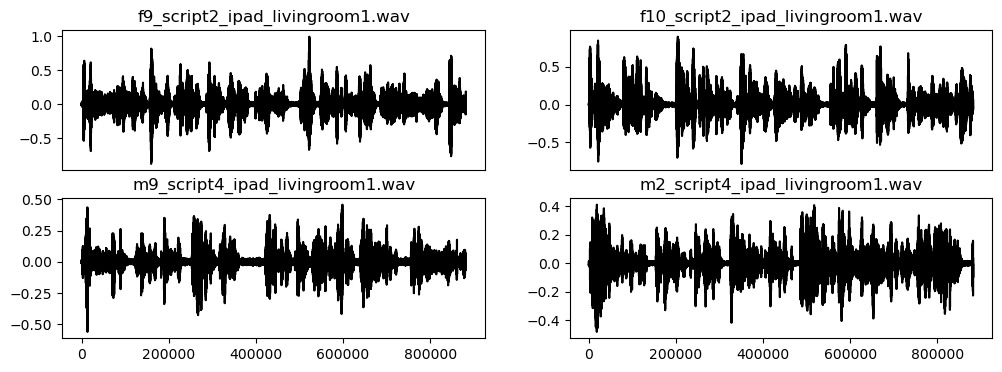

In [26]:
# get all noisy .wav files
fps = glob.glob(os.path.join(config['fps_noisy'], '*.wav'))
fps_random = []

# setup subplot 
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4))

# plot some audio waveforms
for r in range(nrows):
    for c in range(ncols):
        fp_random = fps[np.random.randint(len(fps))]
        audio, sr = librosa.core.load(fp_random, sr= config['sr'], duration=config['sample_length'], offset=config['offset'])
        ax[r][c].plot(audio, c='k')
        # ax[r][c].axis('off')
        ax[r][c].set_title(Path(fp_random).parts[-1])
        if r == 0:
            ax[r][c].set_xticks([])
        # save random audio filepaths
        fps_random.append(fp_random)

# Preprocessing func

In [41]:
# generate mel-filter matrix
mel_filter = librosa.filters.mel(config['sr'], 
                                 config['n_fft'], 
                                 n_mels=config['n_mels'], 
                                 fmin=0.0, 
                                 fmax=None, 
                                 htk=False, 
                                 norm='slaney', 
                                 dtype=np.float32)

def file_name_to_sample_number(file_path):
    
    # for example: '../Data/1noisySpeech/f8_script5_ipad_livingroom1.wav'
    xx = Path(fps[3]).parts[-1]
    speaker_script = '_'.join(xx.split('_')[:-2])

    # get one hot encoded array
    one_hot = tf.one_hot(speaker_script, 100, on_value=None, off_value=None, 
                         axis=None, dtype=tf.uint8, name=None)
    return one_hot


def preprocessing(file_path):
    # path string is saved as byte array in tf.data.dataset -> convert back to str
    if type(file_path) is not str:
        file_path = file_path.numpy()
        file_path = file_path.decode('utf-8')
    
    # load audio data 
    y, _ = librosa.core.load(file_path, sr=config['sr'], mono=config['mono'], offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_best')

    # calculate stft from audio data
    stft = librosa.core.stft(y, n_fft=config['n_fft'], hop_length=config['hop_length'], 
                             win_length=config['win_length'], window=config['window'], 
                             center=config['center'], dtype=np.complex64, pad_mode=config['pad_mode'])

    # filter stft with mel-filter
    mel_spec = mel_filter.dot(np.abs(stft).astype(np.float32) ** config['power'])
    
    # add channel dimension for conv layer  compatibility
    mel_spec = np.expand_dims(mel_spec, axis=-1)

    # get ground truth from file_path string
    one_hot = file_name_to_sample_number(file_path)

    return mel_spec, one_hot



# prepare dataset


In [14]:
# Import libraries

import os
import os.path
import glob
import librosa
import librosa.display
import json
import tensorflow as tf
import random
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [15]:
## Config file

## save global settings in config dict
config = {'sr': 44100,
          'fps_noisy': '../Data/1noisySpeech',
          'fps_produced': '../Data/2producedSpeech',
          'fps_voicefixer': '../Data/3voicefixerOutput',
          'fps_CRN': '../Data/4ppCRNOutput',
          'fps_DF': '../Data/5ppDFOutput',
          'fps_DSP': '../Data/6ppDSPOutput',
          'n_fft': 512,
          'hop_length': 64,
          'win_length': 512,
          'n_mels':32,
          'sample_length': 20,
          'power': 2.0,
          'offset': 6}


# save input shape for model
# config['input_shape'] = (config['n_mels'], config['n_frames'], 1)

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, indent=len(config))

#config

In [20]:

dataset_path = '../Data/2producedSpeech'
json_path = '../Data/0Dataset/data.json'


def prepare_dataset(dataset_path, json_path):

    # data dictionary
    data = {'labels': [],
            'mappings': [],
            'STFTs': [],
            'files': []}

    # loop through all the Dataset folders
    for i, (dirpath, dirnames, filenames) in enumerate (os.walk(dataset_path)):
        filenames.remove('.DS_Store')
        print(f"{filenames}")

                
         # calculate STFT
        for f in filenames:
                         
            #get filepath
            file_path = os.path.join(dirpath, f)

            # load audio file
            signal, _ = librosa.core.load(file_path, sr=config['sr'], mono=True, offset=0.0, duration=None, 
                    dtype=np.float32, res_type='kaiser_best')
                
            stft = librosa.core.stft(signal, n_fft=config['n_fft'], hop_length=config['hop_length'], 
                    win_length=config['win_length'], dtype=np.complex64)
                
            # store data in dict
            # get the speaker and script and store it in 'labels'
            category = f.split('_')[0:2]
            category[0] = category[0] + '_' + category[1]
            data['labels'].append(category[0])

            data['STFTs'].append(stft.tolist())
            data['files'].append(file_path)
        print(f'{data}')   

        # store dict in json file
        with open(json_path, "w") as fp:
             json.dump(data, fp, indent=4)


In [21]:
#%% Main

prepare_dataset(dataset_path, json_path)

['deg_10s_Voicefixer copy.wav', 'deg_10s_Voicefixer.wav']


## Get Labels of train files

In [ ]:
fps_labels_train = {
    'labels':   [],
    'fps':      []}

paths = glob.glob('../Dataset/train/*.wav', recursive=True)

# loop through all the files
for i, f in enumerate(paths):    
    # skip file that doesnt end with ".wav"
    if not f.endswith(".wav"):
        continue
    #print(f)
    # get the speaker and scriptname and store it in 'labels'
    label1 = f.split('/')[-1]
    label = label1.split('_')[0:2]
    fps_labels_train['fps'].append(f)
    fps_labels_train['labels'].append(label[0] + '_' + label[1])


labels = sorted(set(fps_labels_train['labels']))
#labels
#fps_labels_train

#check if it works
idx = np.random.randint(len(labels))

print(fps_labels_train['fps'][idx])
print(fps_labels_train['labels'][idx])


In [ ]:
# Code zum Testen

fps = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train/*.wav')
fps = fps[:2]

data = {'noisy':[],
        'noisy10s':[],
        'produced':[],
        'label':[],
        'fp_noisy':[],
        'fp_produced':[],
}

for file_path in fps:
    # paths for ground truths prod files
    fps_prod = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech/*.wav')

    # path string is saved as byte array in tf.data.dataset -> convert back to str
    if type(file_path) is not str:
        file_path = file_path.numpy()
        file_path = file_path.decode('utf-8')
    

    # load audio data 
    wav = tf.io.read_file(file_path)
    y, _ = tf.audio.decode_wav(wav)

    # cut audio into 10s frames
    seg = 10*44100
    frames = tf.signal.frame(y, seg)


    # get string with speaker and scriptname
    label = file_path.split('/')[-1]
    label = label[:10]
    for filename in fps_prod:
        if label in filename:
            fp = filename
            break

    # load corresponding produced audio file
    wav1 = tf.io.read_file(fp)
    y_truth, _ = tf.audio.decode_wav(wav1)

    data['noisy'].append(y)
    data['frames'].append(frames)
    data['produced'].append(y_truth)
    data['label'].append(label)
    data['fp_noisy'].append(file_path)
    data['fp_produced'].append(fp)


print('--------------------------')
pprint.pprint(data)
print('--------------------------')


'''
#---------------------------
# get 10s segments and store in new dict with labels

data10s = {'noisy':[],
        'produced':[],
        'label':[],
        'fp_noisy':[],
        'fp_produced':[],
}

# cut speech files in 10s chunks
for idx, file in enumerate(data['noisy']):
    file = file.numpy()
    file = list(np.concatenate(file))
    print(len(file))

    # 10 sec
    seg = 10*44100
    # how many 10s segments are in the speech file
    num_seg = int(np.around((len(file)/seg)))
    # 
    for x in range(num_seg):
        snippet = file[seg*x:seg*(x+1)]

        data10s['noisy'].append(snippet)
        data10s['label'].append(data['label'][idx])
# if snippet is shorter than seg(10*44100) --> zero pad



# add channel dimension for conv layer  compatibility
#y = np.expand_dims(y, axis=-1)
#y_truth = np.expand_dims(y_truth, axis=-1)

print('--------------------------')
print('Data with 10s Snippets')
pprint.pprint(data10s)
print('--------------------------')
'''



In [ ]:
# Code zum Testen

fps = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train/*.wav')
fps = fps[:50]

sig1 = []
sig2 = []

for file_path in fps:
    # paths for ground truths prod files
    fps_prod = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech/**.wav')

    # path string is saved as byte array in tf.data.dataset -> convert back to str
    if type(file_path) is not str:
        file_path = file_path.numpy()
        file_path = file_path.decode('utf-8')
    
    # load audio data 
    y, _ = librosa.core.load(file_path, sr=config['sr'], mono=True, offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_best')
    # zero pad file to longest file
    y = librosa.util.fix_length(y, int(config['input_shape'][1]))

    # load corresponding produced wav file and zero pad as well
    # get string with speaker and scriptname
    label = file_path.split('/')[-1]
    label = label[:10]
    print(label)
    for filename in fps_prod:
        if label in filename:
            fp = filename
            print(fp)
            break

    # load corresponding produced audio file
    y_truth, _ = librosa.core.load(fp, sr=config['sr'], mono=True, offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_best')
    # zero pad file to longest file
    y_truth = librosa.util.fix_length(y_truth, int(config['input_shape'][1]))

    sig1.append(y)
    sig2.append(y_truth)
    # add channel dimension for conv layer  compatibility
    y = np.expand_dims(y, axis=-1)
    y_truth = np.expand_dims(y_truth, axis=-1)


x= 32


fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.waveshow(sig1[x], sr=config['sr'], ax=ax[0])
ax[0].set(title=Path(file_path).parts[-1])
ax[0].label_outer()


librosa.display.waveshow(sig2[x], sr=config['sr'], ax=ax[1])
ax[1].set(title=Path(fp).parts[-1])
ax[1].label_outer()